In [2]:
import numpy as np
from matplotlib import pyplot as plt
from tenpy.models.hubbard import BoseHubbardModel
from tenpy.networks.mps import MPS
from tenpy.algorithms import dmrg

import numpy as np
import matplotlib.pyplot as plt

from tenpy.models.model import CouplingMPOModel, CouplingModel, MPOModel
from tenpy.models.lattice import Chain, SimpleLattice, Lattice
from tenpy.networks.site import BosonSite
from tenpy.tools.params import asConfig

In [5]:
#USER-DEFINED MODEL
class HardCoreBosonModel(CouplingMPOModel,MPOModel):
    
    def __init__(self, model_params):
    
        # 0) read out/set default parameters
        model_params = asConfig(model_params, "BoseModel")
        
        L = model_params.get('L', 12)                 #length of the chain
        t = np.asarray(model_params.get('t', 1.))     #tunnelling rate
        rc = model_params.get('rc', 1.)               #range of soft-shoulder interaction
        V = np.asarray(model_params.get('V', 1.))     # soft-shoulder interaction
        bc_MPS = model_params.get('bc_MPS', 'finite') #boundary condition of MPS
        filling = model_params.get('filling', 0.5)    #average site filling 
        n_max = model_params.get('n_max', 1)          #max number of bosons per site
        conserve = model_params.get('conserve', 'N')  
        
        
        # 3) local physical site
        site = BosonSite(Nmax=n_max, conserve=conserve, filling=filling)
        
        # 4) lattice #ARE THESE PARAMETERS OK?
        bc = 'open' if bc_MPS == 'finite' else 'periodic'
        lat = Chain(L, site, bc=bc, bc_MPS=bc_MPS)
        
        # 5) initialize CouplingModel
        CouplingModel.__init__(self, lat)
        
        
        # 6) add terms of the Hamiltonian
        
        #NEAREST NEIGHBOR INTERACTION 
        for u1, u2, dx in self.lat.pairs['nearest_neighbors']:
            self.add_coupling(-t, u1, 'Bd', u2, 'B', dx, plus_hc=True)
            
        #SOFT SHOULDER INTERACTION
        for int_range in range(2,rc+1):
            (u1, u2, dx) = self.lat.find_coupling_pairs(max_dx=L, cutoff=rc).get(int_range)[0]
            self.add_coupling(V, u1, 'N', u2, 'N', dx, plus_hc=False)
        
        # 7) initialize H_MPO
        MPOModel.__init__(self, lat, self.calc_H_MPO())
    
    

In [15]:
#DMRG function

def DMRG_Bose_finite(model_params):
    
    #read and set default values
    t = model_params.get('t',1)
    V = model_params.get('V',1)
    L = model_params.get('L',12)
    
    print("finite DMRG, Hard-Core Bose Model")
    print("t={t:.2f}, V={V:.2f}".format(t=t, V=V))
    
    
    #define model
    M = HardCoreBosonModel(model_params)
    
    #define initial MPS
    psi = MPS.from_product_state(M.lat.mps_sites(), [1,'vac']*int(L/2), "finite")
    
    #dmrg algorithm parameters
    dmrg_params = {
        'mixer': None,  # setting this to True helps to escape local minima
        'max_E_err': 1.e-10,
        'trunc_params': {
            'chi_max': 30,
            'svd_min': 1.e-10
        },
        'combine': True
    }
    
    #call a 'DMRG engine' explicitly
    eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
    info, psi = eng.run()  # equivalent to dmrg.run() up to the return parameters.
    
    return info, psi


In [14]:
#dictionary of model parameters 
model_params = {
    'bc_MPS' : 'finite',          #boundary conditions for MPS
    'conserve' : 'N',             #what should be conserved
    'filling' : 3/4,              #float, average filling
    'L' : 48,                     #length of the Chain
    'n_max' : 1,                  #maximum number of bosons per site
    't' : 0,                      #tunnelling rate
    'V' : 1,                      #potential
    'rc': 4                       #range of soft-shulder ionteraction
}

#run DMRG
info, psi = DMRG_Bose_finite(model_params)


print("E:",info)
print(psi) #non mi piacciono le bond dimensions, non so perché vengono così


finite DMRG, Hard-Core Bose Model
t=0.00, V=1.00
E: 22.0
MPS, L=48, bc='finite'.
chi: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
first two sites: BosonSite(1, 'N', 0.750000) BosonSite(1, 'N', 0.750000)
first two forms:(1.0, 0.0) (1.0, 0.0)


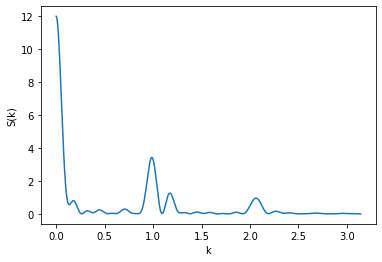

In [20]:
#calculate correlation function ???
correlation_matrix = psi.correlation_function('N','N') #- model_params.get('filling')**2

def structure_factor(k, corr_matrix, model_params):
    
    L = model_params.get('L', 48)
    res = 0

    for i in range(L):
        for j in range(L):
             res += (corr_matrix[i,j]/L) * (np.cos(k*(i-j)) + np.imag(np.sin(k*(i-j)))) #???
    
    return res

k = np.arange(0,np.pi,0.001)

plt.figure(1)
plt.plot(k,structure_factor(k,correlation_matrix, model_params))
plt.ylabel("S(k)")
plt.xlabel("k")
plt.show()

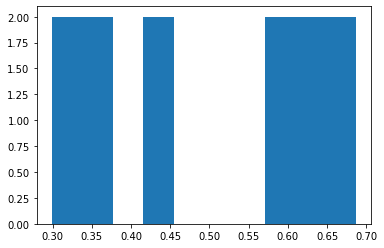

In [37]:
plt.figure(1)

plt.hist(psi.expectation_value('N'))
plt.show()
